In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [2]:
fetal = pd.read_csv("fetal_health.csv")

In [3]:
target = fetal['fetal_health']
features = fetal.drop('fetal_health', axis = 1)

# encode the target data
le = preprocessing.LabelEncoder()
encoded_target = pd.DataFrame(le.fit_transform(target))

In [39]:
X = preprocessing.StandardScaler().fit_transform(X=features)
y = encoded_target.values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
from sklearn.model_selection import GridSearchCV
classifier = neighbors.KNeighborsClassifier(n_neighbors=5, metric='hamming')
classifier.fit(X_train, y_train.ravel())

KNeighborsClassifier(metric='hamming')

In [41]:
# test preds accuracy
test_preds = classifier.predict(X_test)
metrics.accuracy_score(y_test, test_preds)

0.8873239436619719

In [148]:
%%capture --no-stdout
# from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 35))
distance_metrics = sorted(neighbors.VALID_METRICS['brute'])
param_grid = dict(n_neighbors=k_range)

# defining parameter range
best_neighbor_numbers_ = {}
for i in distance_metrics:
    try:
        classifier2 = neighbors.KNeighborsClassifier(metric=i)
        grid = GridSearchCV(classifier2, param_grid, cv = 10,
                            scoring='accuracy', return_train_score=False,
                            verbose=1)

        # fitting the model for grid search
        grid_search=grid.fit(X_train, y_train.ravel())
        # best_neighbor_number = grid_search.best_params_['n_neighbors']
        # best_neighbor_numbers.append(grid_search.best_params_['n_neighbors'])
        best_neighbor_numbers_[i] = grid_search.best_params_['n_neighbors']
    except Exception as e:
        print(e)

Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 340 fits
Fitting 10 folds for each of 34 candidates, totalling 3

In [157]:
# best_neighbor_numbers_
distance_metrics

['braycurtis',
 'canberra',
 'chebyshev',
 'cityblock',
 'correlation',
 'cosine',
 'dice',
 'euclidean',
 'hamming',
 'haversine',
 'jaccard',
 'kulsinski',
 'l1',
 'l2',
 'mahalanobis',
 'manhattan',
 'matching',
 'minkowski',
 'nan_euclidean',
 'precomputed',
 'rogerstanimoto',
 'russellrao',
 'seuclidean',
 'sokalmichener',
 'sokalsneath',
 'sqeuclidean',
 'yule']

In [156]:
%%capture --no-stdout
all_accuracies = {}
for i in range(0, len(distance_metrics)):
    try:
        # print(i)
        # print(best_neighbor_numbers_[i])
        which_metric = distance_metrics[i]
        how_many_neighbors = best_neighbor_numbers_[which_metric]
        newer_classifier = neighbors.KNeighborsClassifier(metric=which_metric,n_neighbors=how_many_neighbors)
        newer_classifier.fit(X_train, y_train.ravel())
        test_preds = newer_classifier.predict(X_test)
        all_accuracies[which_metric] = accuracy_score(y_test, test_preds)
    except BaseException as e:
        print(f'{distance_metrics[i]} (number {i}) did not work: {e}')

haversine (number 9) did not work: Haversine distance only valid in 2 dimensions
mahalanobis (number 14) did not work: The 'VI' parameter is required for the mahalanobis metric when Y is passed.
precomputed (number 19) did not work: 'precomputed'
seuclidean (number 22) did not work: __init__() takes exactly 1 positional argument (0 given)


In [158]:
# get the highest accuracy metric
max_accuracy_metric = max(all_accuracies, key=all_accuracies.get)
max_accuracy_metric

'cityblock'

In [159]:
# try with a range of neighbor numbers
cityblock_score_list = []
for i in k_range:
    cityblock_classifier = neighbors.KNeighborsClassifier(n_neighbors=i, metric='cityblock')
    cityblock_classifier.fit(X_train, y_train.ravel())
    cityblock_preds = cityblock_classifier.predict(X_test)
    cityblock_score_list.append(metrics.accuracy_score(y_test.ravel(), cityblock_preds))

Text(0, 0.5, 'Testing Accuracy')

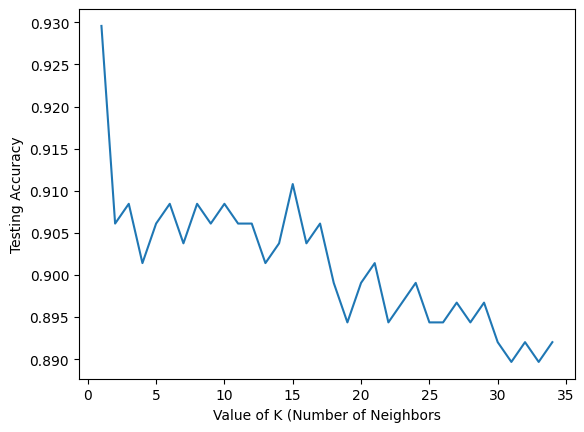

In [160]:
%matplotlib inline
plt.plot(k_range, cityblock_score_list)
plt.xlabel('Value of K (Number of Neighbors')
plt.ylabel('Testing Accuracy')

In [161]:
clustering = DBSCAN(eps=.8, metric='cityblock', min_samples=25)
clusters = clustering.fit(np.array(target).reshape(-1, 1))
# clustering.get_params()
# clustering.labels_

In [162]:
core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [163]:
n_noise_

0

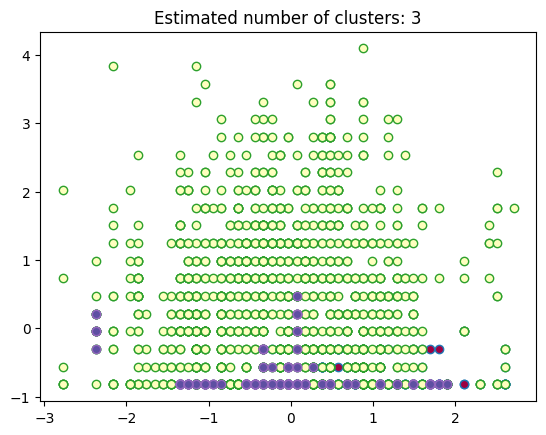

In [164]:
labels = clusters.labels_

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        # markeredgecolor="r",
        markersize=6,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        # markeredgecolor="y",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()